In [13]:
import pandas as pd 
import random
from datetime import datetime, timedelta
import sqlite3

# Drone Surveillance Data Pipeline
## Step 1: Data Generation and ETL
Generating simulated drone surveillance data and loading it into SQLite for analysis. Skills: Python, SQL.

In [150]:
# Generate 1000 rows of fake drone data
data = []
start_time = datetime.now()
for i in range(5000):
    time = start_time + timedelta(minutes=i)  # Timestamps over 5000 minutes
    lat = 32.5 + random.uniform(-0.5, 0.5)    # Around San Diego
    lon = -117.0 + random.uniform(-0.5, 0.5)  # Same
    alt = random.triangular(50, 30000, 500)  # Altitude in feet
    data.append([time, lat, lon, alt])

# Create DataFrame and save to CSV
df = pd.DataFrame(data, columns=['timestamp', 'latitude', 'longitude', 'altitude'])
df.to_csv('drone_data.csv', index=False)
print("Generated drone_data.csv with 1000 rows.")

Generated drone_data.csv with 1000 rows.


In [151]:
# Extract: Read CSV
df = pd.read_csv('drone_data.csv')
df.head()

,timestamp,latitude,longitude,altitude
0,2025-03-14 20:29:04.889681,32.930582,-116.543378,17146.132486
1,2025-03-14 20:30:04.889681,32.339966,-117.143351,16356.983819
2,2025-03-14 20:31:04.889681,32.069859,-116.597385,8008.717435
3,2025-03-14 20:32:04.889681,32.664425,-116.969148,8543.995234
4,2025-03-14 20:33:04.889681,32.129410,-117.152584,5059.317757


In [152]:
df.shape

(5000, 4)

In [153]:
# Transform: Basic cleaning
df = df[(df['altitude'] >= 0) & (df['altitude'] <= 30000)]  # Filter outliers
df['timestamp'] = pd.to_datetime(df['timestamp'])          # Ensure timestamp is datetime
print(f"Transformed data: {len(df)} rows after cleaning.")

Transformed data: 5000 rows after cleaning.


In [154]:
# Load: Into SQLite
conn = sqlite3.connect('drones.db')  # Creates drones.db
df.to_sql('drones', conn, if_exists='replace', index=False)
print("Loaded data into SQLite database 'drones.db'.")

Loaded data into SQLite database 'drones.db'.


In [155]:
# Query: Count high-altitude drones
conn = sqlite3.connect('drones.db')
cursor = conn.cursor()
query = "SELECT COUNT(*) FROM drones WHERE altitude > 10000"
result = cursor.execute(query).fetchone()[0]
print(f"Drones above 10000 ft: {result}")
conn.close()

Drones above 10000 ft: 2295


In [156]:
conn = sqlite3.connect('drones.db')
cursor = conn.cursor()

In [157]:
over_20000 = cursor.execute('SELECT COUNT(*) FROM drones WHERE altitude > 20000').fetchone()[0]
print(f"Drones above 20000 ft: {over_20000}")
avg_alt = cursor.execute('SELECT AVG(altitude) FROM drones').fetchone()[0]
print(f"Average drone altitude: {round(avg_alt, 2)}")
conn.close()

Drones above 20000 ft: 583
Average drone altitude: 10307.44


# Step 2: Visualization and Analysis
Exploring drone surveillance data with Pandas and Matplotlib to uncover patterns and visualize insights.

In [160]:
conn = sqlite3.connect('drones.db')
df = pd.read_sql_query("SELECT * FROM drones", conn)
conn.close()

df.head()

,timestamp,latitude,longitude,altitude
0,2025-03-14 20:29:04.889681,32.930582,-116.543378,17146.132486
1,2025-03-14 20:30:04.889681,32.339966,-117.143351,16356.983819
2,2025-03-14 20:31:04.889681,32.069859,-116.597385,8008.717435
3,2025-03-14 20:32:04.889681,32.664425,-116.969148,8543.995234
4,2025-03-14 20:33:04.889681,32.129410,-117.152584,5059.317757


In [161]:
# Summary stats
avg_altitude = df['altitude'].mean()
max_altitude = df['altitude'].max()
min_altitude = df['altitude'].min()
zone_counts = df.groupby(['latitude', 'longitude']).size().reset_index(name='sightings')

In [162]:
zone_counts.head()

,latitude,longitude,sightings
0,32.000156,-117.080038,1
1,32.000653,-117.000635,1
2,32.000992,-116.567464,1
3,32.001909,-117.397468,1
4,32.001932,-117.436982,1


In [163]:
print(f"Average Altitude: {round(avg_altitude, 2)} ft")
print(f"Maximum Altitude: {max_altitude} ft")
print(f"Minimum Altitude: {min_altitude} ft")

print(f"Total unique zones: {len(zone_counts)}") 
print("Top 5 Most Active Zones:")
print(zone_counts.sort_values('sightings', ascending=False).head())

Average Altitude: 10307.44 ft
Maximum Altitude: 29526.84783641327 ft
Minimum Altitude: 99.37805810150697 ft
Total unique zones: 5000
Top 5 Most Active Zones:
       latitude   longitude  sightings
0     32.000156 -117.080038          1
3330  32.669787 -116.543246          1
3337  32.671545 -117.177744          1
3336  32.671542 -117.417078          1
3335  32.670919 -116.592275          1


In [164]:
import matplotlib.pyplot as plt

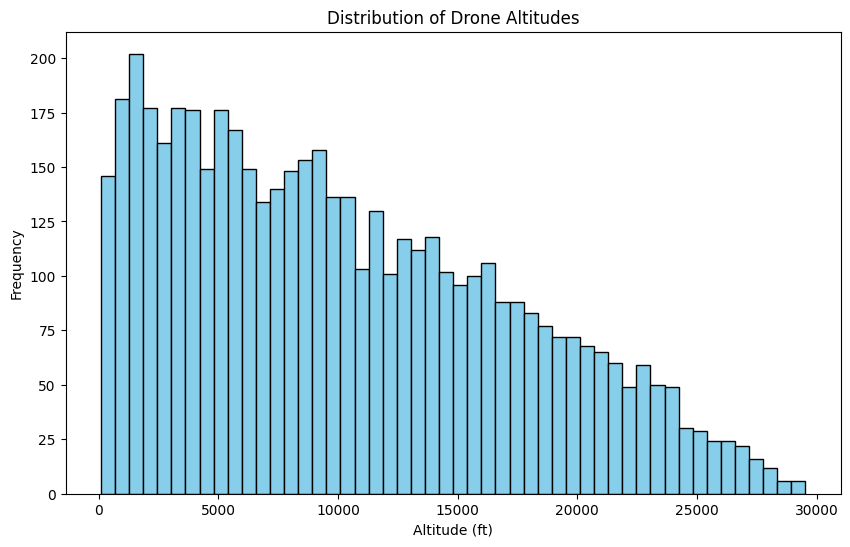

In [168]:
# Histogram of altitudes
plt.figure(figsize=(10, 6))
plt.hist(df['altitude'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Drone Altitudes')
plt.xlabel('Altitude (ft)')
plt.ylabel('Frequency')
plt.show()

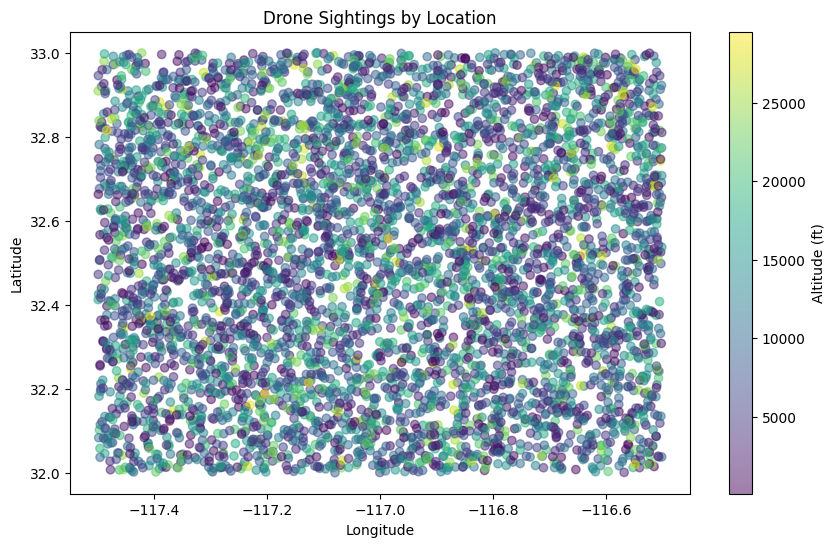

In [169]:
# Scatter plot of drone locations
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['altitude'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Altitude (ft)')
plt.title('Drone Sightings by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

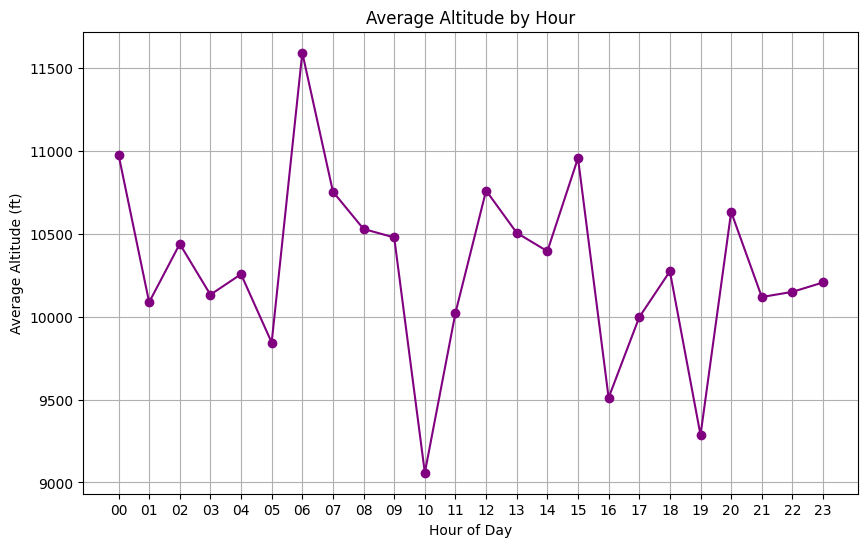

In [170]:
# Hourly altitude trend
conn = sqlite3.connect('drones.db')
query = """
SELECT strftime('%H', timestamp) as hour, AVG(altitude) as avg_altitude
FROM drones
GROUP BY strftime('%H', timestamp)
ORDER BY hour
"""
hourly_alt = pd.read_sql_query(query, conn)
conn.close()

plt.figure(figsize=(10, 6))
plt.plot(hourly_alt['hour'], hourly_alt['avg_altitude'], marker='o', color='purple')
plt.title('Average Altitude by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Altitude (ft)')
plt.grid(True)
plt.show()

## Step 2 Summary
- Generated and loaded 5,000 drone sightings from SQLite into Pandas, simulating ~3.5 days of data around San Diego (lat: 32-33°, lon: -117.5 to -116.5°).
- Computed summary stats: average altitude ~10,307 ft, max ~29,526 ft, min ~99 ft; identified 5,000 unique lat/lon zones (all with 1 sighting due to continuous random generation).
- Visualized insights with Matplotlib:
  - **Altitude histogram**: Shows a right-skewed distribution with a peak near 500 ft, reflecting the triangular distribution used.
  - **Spatial scatter plot**: Displays a uniform spread of sightings, lacking realistic clustering (e.g., near bases or urban areas). This is expected with fake, randomly generated data and will improve with real-world data showing natural patterns.
  - **Hourly trend**: Reveals average altitude by hour over a 24-hour cycle, with random variation around ~10,000 ft.
- Next: Real-time simulation (Step 3) or integration of real-world drone surveillance data for more realistic analysis.